In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
import random
import sklearn
from random import randrange
from collections import Counter

In [ ]:
class KNearstNeighbour:
  def __init__(self,k):
    self.k = k
  def train(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train
  def predict(self,X_test):
    distances = self.euclidean_distance(X_test)
    return self.predict_labels(distances) 
  def euclidean_distance(self,X_test):
    #We want to compute distance 
    #for each test points we want to compute
    #the distance with all other train points
    n_test = X_test.shape[0]
    n_train = self.X_train.shape[0]
    distances = np.zeros((n_test,n_train))
    for i in range(n_test):
      for j in range(n_train):
        distances[i,j]=np.sqrt(np.sum((X_test[i, :] - self.X_train[j, :]) ** 2))      
    return distances

  def predict_labels(self,distances):
      n_test = distances.shape[0]
      y_pred = np.zeros(n_test)
      for i in range(n_test):
        idx = np.argsort(distances[i,:])
        kn = self.y_train[idx[:self.k]]
        kn = kn.flatten()
        
        most_common = Counter(kn).most_common(self.k)
        if self.k > 1:
          #keep decreasing the k untill there's no ties
          while most_common[0][1] == most_common[1][1]:
            self.k = self.k - 1
            idx = argsort(distances[i,:])
            kn = self.y_train(idx[:self.k])
            kn = kn.flatten()
            most_common = Counter(kn).most_common(self.k)
        
        y_pred[i] = most_common[0][0]
      return y_pred.reshape(len(y_test),1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def construct_DataMatrix():
  DIR = 'drive/MyDrive/Dataset/'
  D = []
  y = []
  for i in range(1,41):
    path = os.path.join(DIR,'s'+str(i))
    for j in range(1,11):
      img_path = os.path.join(path,str(j)+".pgm")
      #print(img_path)
      y.append(i)
      arr = cv2.imread(img_path,0)
      arr = arr.flatten().reshape(10304)
      D.append(arr) 
  
  D = np.array(D)
  y = np.array(y).reshape(400,1)
  return D,y

In [ ]:
img = cv2.imread('drive/MyDrive/Dataset/s1/1.pgm',0)
print("Image Before Flattening", img.shape)
img = img.flatten().reshape(10304, 1)
print("Image After Flattening", img.shape)
print("Data Matrix = " ,D.shape)


Image Before Flattening (112, 92)
Image After Flattening (10304, 1)
Data Matrix =  (400, 10304)


In [ ]:
def train_test_split(D,y,split):
  #if ratio 50%
  #do even-odd split
  #odd for train
  #even for test
  if split == 0.5:
    y_train = y[1::2]
    y_test = y[::2]

    X_train = D[1::2] 
    X_test = D[::2]
       
  #else split according to split ratio
  #but we need to shuffle D and concate labels before splitting
  else:
    X_train = []
    y_train = []

    train_size = split*len(D)
    X_test = list(D)
    y_test = list(y)

    while len(X_train) < train_size:
      index = randrange(len(X_test))
      X_train.append(X_test.pop(index))
      y_train.append(y_test.pop(index))

  return X_train,X_test,y_train,y_test,y

In [ ]:
D,y = construct_DataMatrix()
X_train,X_test,y_train,y_test,y = train_test_split(D,y,0.7)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)




In [ ]:
# D,y = construct_DataMatrix()
# X_train,X_test,y_train,y_test,y = train_test_split(D,y,0.7)
print("Shape of X_train, X_test respectively  =  ", X_train.shape,X_test.shape)
print("Shape of y_train, y_test respectively  =  ", y_train.shape,y_test.shape)

Shape of X_train, X_test respectively  =   (280, 10304) (120, 10304)
Shape of y_train, y_test respectively  =   (280, 1) (120, 1)


In [ ]:
class PCA:
  def __init__(self,X_train,X_test):
    self.X_train = X_train
    self.X_test = X_test
    self.Z_train = None
    self.Z_test = None
    self.value = None
    self.vector = None
    
  def fit(self):
    mu_train = np.mean(self.X_train,axis=0)
    mu_test = np.mean(self.X_test,axis = 0)

    self.Z_train = self.X_train - mu_train.T
    self.Z_test = self.X_test - mu_test.T


    cov = np.cov(self.Z_train.T,bias=True)
    print(cov.shape)
    self.value, self.vector = np.linalg.eigh(cov)
    idx = self.value.argsort()[::-1]   
    self.value = self.value[idx]
    self.vector = self.vector[:,idx]
    return self.value,self.vector
  
  def findNumberOfComponents(self,alpha):
   #vector represents eigen vector
   #value represents eigen values
   #Alpha represents the desired explained variance / information
   #the function returns number of components/axis to achieve the given alpha
    variance_explained = np.array(((self.value/np.sum(self.value))))
    n_components = 0
    for i in range(len(variance_explained)):
      if alpha <= 0:
        break
      else:
        alpha -= variance_explained[i]
        n_components = n_components +1

    return n_components

  def transform(self,n_components):
    W = self.vector[:,0:n_components]  
    pca_train = np.dot(W.transpose() , self.Z_train.transpose()).transpose()  
    pca_test = np.dot(W.transpose() , self.Z_test.transpose()).transpose()
      
    return pca_train,pca_test


In [ ]:
pca_model = PCA(X_train,X_test)
value,vector = pca_model.fit()  

(10304, 10304)


Alpha With Value = 0.8 Requires 40 Axis
Alpha With Value = 0.85 Requires 59 Axis
Alpha With Value = 0.9 Requires 92 Axis
Alpha With Value = 0.95 Requires 148 Axis
The Model Accuracy With Alpha =  0.8  Is  95.83333333333334 %
The Model Accuracy With Alpha =  0.85  Is  95.0 %
The Model Accuracy With Alpha =  0.9  Is  95.0 %
The Model Accuracy With Alpha =  0.95  Is  94.16666666666667 %


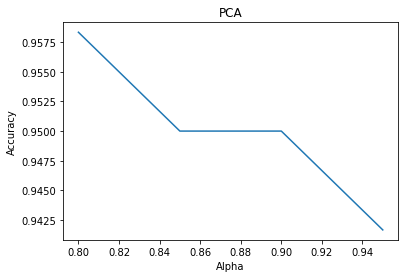

In [ ]:
alpha = [0.8,0.85,0.9,0.95]
accuracy = []

for alpha_value in alpha:
  n_components =  pca_model.findNumberOfComponents(alpha_value)
  pca_train,pca_test = pca_model.transform(n_components)

  print("Alpha With Value =",alpha_value,"Requires",n_components,"Axis")
  
  KNN = KNearstNeighbour(k=1)
  KNN.train(pca_train,y_train)
  y_pred = KNN.predict(pca_test) 
  arr = (np.sum(y_pred == y_test) / len(y_test))
  accuracy.append(arr)
  
for i in range(len(accuracy)):
  print("The Model Accuracy With Alpha = ",alpha[i]," Is ",accuracy[i]*100 ,"%")

plt.plot(alpha,accuracy)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("PCA")
plt.show()

In [ ]:
class LDA:
  def __init__(self,X_train,X_test,y_train,y):
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y = y
    self.value = None
    self.vector = None

  def fit(self):
    classes = np.unique(y).reshape(40,)
    self.y_train = self.y_train.reshape(y_train.shape[0],)
    mu_sample = np.mean(self.X_train,axis=0)
    
    n_features = self.X_train.shape[1]
    B = np.zeros((n_features,n_features))
    S = np.zeros((n_features,n_features))

    for c in classes:
      X_class = self.X_train[c==self.y_train]
      mu_class = np.mean(X_class,axis = 0)
      n = X_class.shape[0]
      B += n*np.dot((mu_class - mu_sample),(mu_class - mu_sample).T)
      S += np.cov((X_class - mu_class).T,bias = False) 
      
    Sinv = np.linalg.inv(S)
    SinvB = np.dot(Sinv,B)

    self.value, self.vector = np.linalg.eigh(SinvB)
    idx = self.value.argsort()[::-1]   
    self.value = self.value[idx]
    self.vector = self.vector[:,idx]
    
    return self.value,self.vector

  def transform(self,n_components):
    W = self.vector[:,:n_components]
    lda_train = np.dot(W.T,self.X_train.T).T
    lda_test = np.dot(W.T,self.X_test.T).T
   
    return lda_train,lda_test
    

In [ ]:
LDA_model = LDA(X_train,X_test,y_train,y)
value2,vector2 = LDA_model.fit()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=39)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)
print(X_train)
print(X_test.shape)
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#cm = confusion_matrix(y_test, y_pred)
#print(cm)
print('Accuracy' ,accuracy_score(y_test, y_pred))

[[-7.41928191e+00  1.02853698e-01 -1.26475676e+00 ... -3.92956195e-01
  -2.01947728e+00 -1.29346313e+00]
 [-6.63046337e+00 -2.36434606e+00  1.99620548e-01 ... -1.45541328e+00
  -2.76032675e-01 -1.17263639e-01]
 [-5.14978701e+00 -8.05363673e-01 -1.80153982e+00 ... -1.00845205e+00
   2.46716713e+00 -1.77434992e-01]
 ...
 [-5.84518113e+00  2.62345328e+00  2.52885592e+00 ...  6.91498657e-01
   9.52788685e-01 -1.35094999e-01]
 [-5.75857755e+00  1.69959814e+00  2.57407773e+00 ...  3.03681955e-01
   2.85487953e+00 -2.46223028e+00]
 [-4.47146094e+00  1.72921574e+00  2.57094113e+00 ...  4.58751886e-01
   1.26733481e-03  3.29353413e-01]]
(200, 39)
Accuracy 0.965
[[-9.69412180e+03  3.30233520e+03  1.85575542e+03 ... -6.19734463e+01
   3.68759633e+01 -4.82406150e+01]
 [-9.49730393e+03  3.11826010e+03  1.47726438e+03 ... -8.67543428e+01
   3.85935975e+01 -5.31166179e+01]
 [-9.24146179e+03  3.74494939e+03  1.62112006e+03 ... -1.11836801e+02
  -3.81870611e+01 -5.52290959e+01]
 ...
 [-8.20410452e+03  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
 print(X_train)
lda_train,lda_test = LDA_model.transform(39)
#print(lda_train)

[[ 60  60  62 ...  32  34  34]
 [ 63  53  35 ...  41  10  24]
 [ 43  50  41 ... 158 153 169]
 ...
 [123 121 126 ...  40  35  42]
 [125 119 124 ...  36  39  40]
 [125 124 124 ...  36  35  34]]


In [ ]:
#print((S.transpose()==S).all())
#print((Sinv.transpose()== -Sinv).all())
#print(Sinv)
print(np.dot(np.linalg.inv(S),S))
#print(np.dot(Sinv,S))

[[ 1.00000000e+00  2.06880837e-32 -1.16828566e-32 ... -1.21738032e-32
   5.58904870e-31  4.43734259e-32]
 [ 4.55633948e-32  1.00000000e+00  7.26383286e-33 ... -8.90665562e-32
  -4.30637936e-32 -2.78073469e-31]
 [-5.00591774e-32  1.11077235e-31  1.00000000e+00 ...  6.82346334e-32
   2.26981376e-32 -4.66017269e-32]
 ...
 [ 3.06896937e-32 -4.80211372e-32 -5.86547231e-34 ...  1.00000000e+00
  -6.47690240e-32 -2.10773773e-31]
 [ 1.14015053e-31 -1.45985490e-32 -5.41211893e-32 ...  6.07630897e-32
   1.00000000e+00 -3.94430453e-32]
 [-7.70371978e-34 -7.31853379e-32 -3.54040091e-33 ... -1.25378039e-31
   4.62223187e-33  1.00000000e+00]]


In [ ]:
lda_train,lda_test = LDA_model.transform(39)
KNN = KNearstNeighbour(k=1)
KNN.train(lda_train,y_train)
y_pred = KNN.predict(lda_test) 
acc = (np.sum(y_pred == y_test) / len(y_test))
print("The Model Accuracy Is",acc*100, "%")

The Model Accuracy Is 91.66666666666666 %


The Model Accuracy With 1 Neighbours Is 0.9666666666666667 	 The Model Accuracy With 1 Neighbours Is 0.9416666666666667
The Model Accuracy With 3 Neighbours Is 0.8833333333333333 	 The Model Accuracy With 3 Neighbours Is 0.8666666666666667
The Model Accuracy With 5 Neighbours Is 0.8083333333333333 	 The Model Accuracy With 5 Neighbours Is 0.7666666666666667
The Model Accuracy With 7 Neighbours Is 0.8 	 The Model Accuracy With 7 Neighbours Is 0.6916666666666667


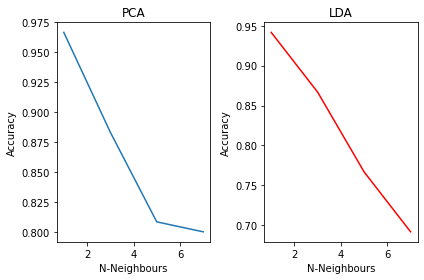

In [ ]:
#Classifier Tuning
neighbours = [1,3,5,7]
accuracy_lda = []
accuracy_pca = []

for n in neighbours:
  KNN = KNearstNeighbour(k = n)
  KNN.train(lda_train,y_train)
  y_pred_lda = KNN.predict(lda_test) 
  arr_lda = (np.sum(y_pred_lda == y_test) / len(y_test))
  accuracy_lda.append(arr_lda)
  #
  KNN.train(pca_train,y_train)
  y_pred_pca = KNN.predict(pca_test) 
  arr_pca = (np.sum(y_pred_pca == y_test) / len(y_test))
  accuracy_pca.append(arr_pca)


for i in range(len(accuracy_pca)):
  print("The Model Accuracy With",neighbours[i],"Neighbours Is", accuracy_pca[i],"\t",
        "The Model Accuracy With",neighbours[i],"Neighbours Is", accuracy_lda[i])

plt.subplot(1, 2, 1)
plt.plot(neighbours,accuracy_pca)
plt.xlabel("N-Neighbours")
plt.ylabel("Accuracy")
plt.title("PCA")

plt.subplot(1, 2, 2)
plt.plot(neighbours,accuracy_lda, color = 'r')
plt.xlabel("N-Neighbours")
plt.ylabel("Accuracy")
plt.title("LDA")
plt.tight_layout()
plt.show()



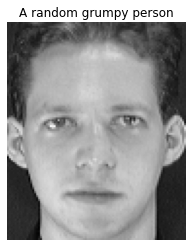

(112, 92)


In [ ]:
img = cv2.imread('drive/MyDrive/Dataset/s1/1.pgm', 0) # '0' for reading grayscale images
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('A random grumpy person')
plt.show()
IMG_SHAPE = img.shape

print(IMG_SHAPE)


(280, 44)
(44,)


AttributeError: ignored

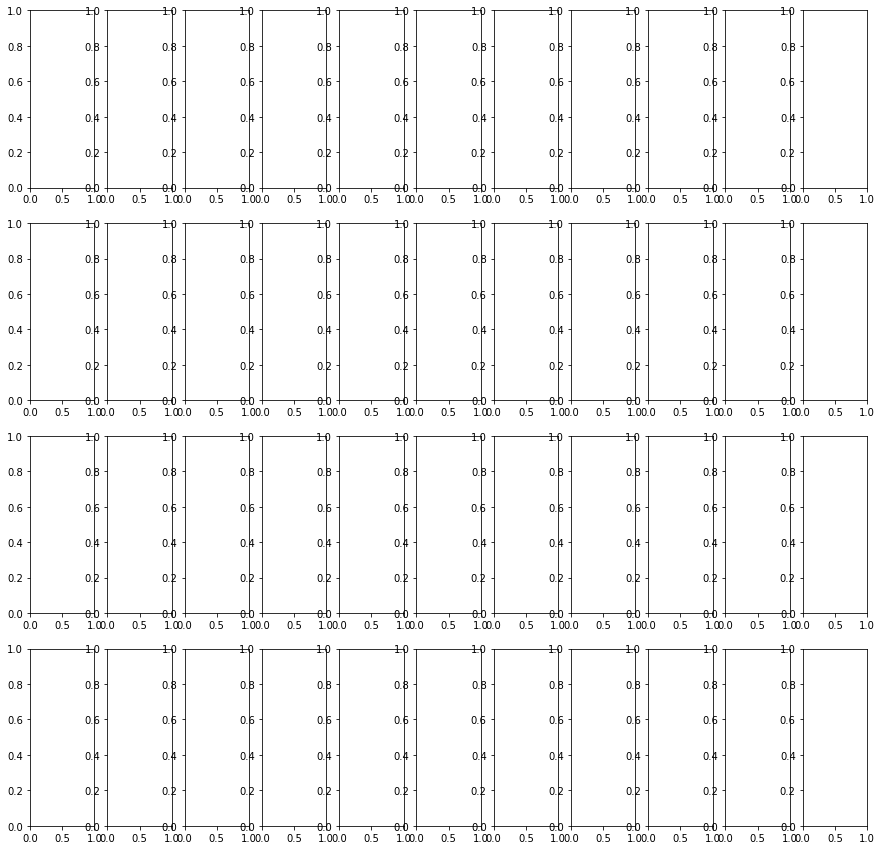

In [ ]:
pca_train,pca_test = pca_model.transform(44)
print(pca_train.shape)
print(pca_train[0].shape)
# pca_train[0].reshape(44,1)
fig, axes = plt.subplots(4, 11, figsize = (15, 15))
axes.imshow(pca_train[0].reshape(44,1), cmap = 'gray')
#pca_train[0].reshape(IMG_SHAPE)

In [ ]:
print(pca_train.shape)

(280, 44)


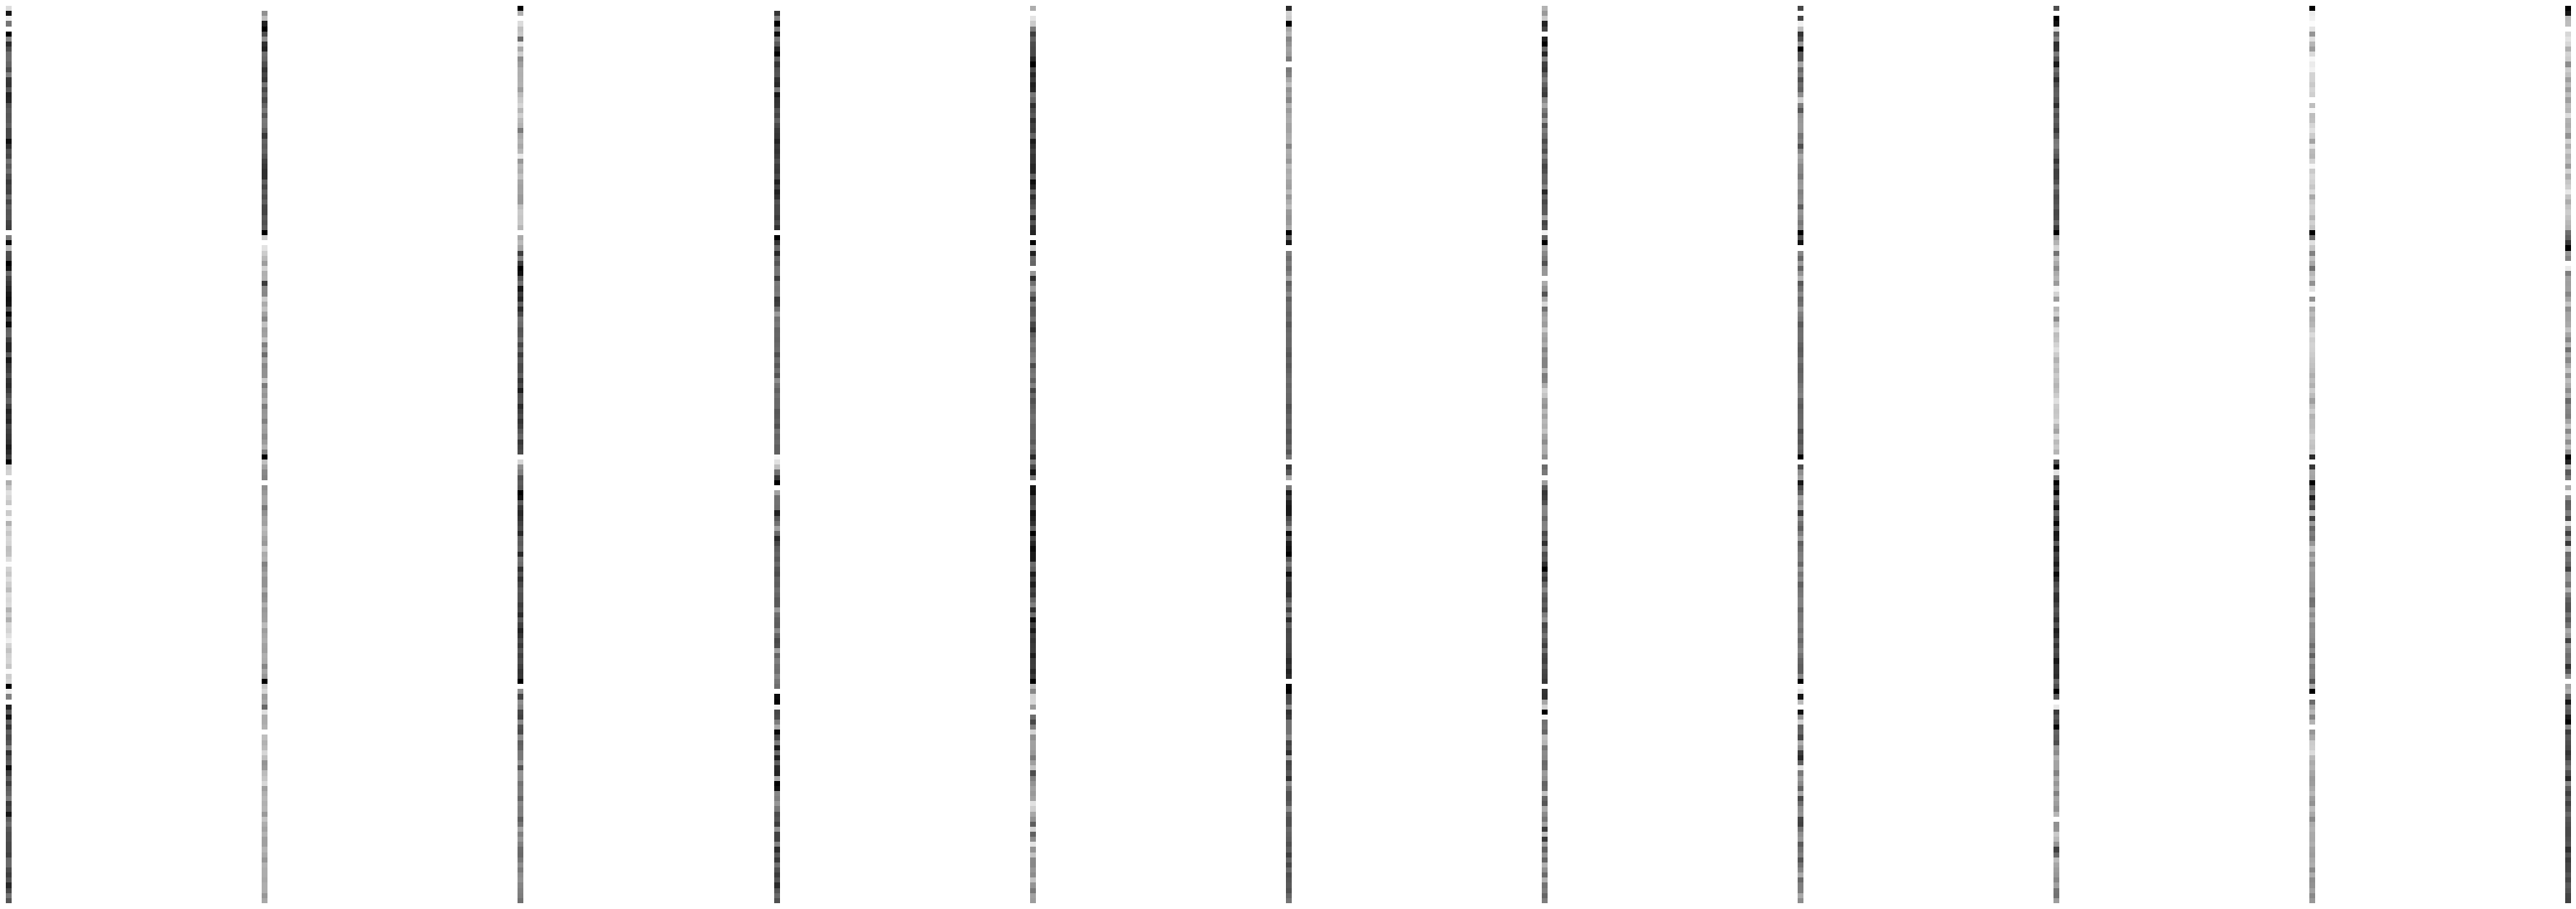

In [ ]:
fig, axes = plt.subplots(4, 11, figsize = (50, 15))
for (ax,i) in zip(axes.flat, range(pca_train.shape[0])):
    ax.imshow(pca_train[i].reshape(44, 1), cmap = 'gray')
    ax.axis('off')
fig.tight_layout(pad = 0)

In [ ]:
# vector = vector2[:,:39].T
vectorx = vector[:,:44].T
print(vectorx.shape)

# print(vector2.shape)
# U_reduced is same as the 'components' matrix used previously
A_0 = np.dot(pca_train[0], vectorx)
print(A_0.shape)

# Displaying the images:
A_0 = A_0.reshape(112, 92)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Reconstructed Image')
plt.imshow(A_0, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Actual Image')
plt.imshow(D[0].reshape(112, 92), cmap='gray')
plt.tight_layout(pad = 0)
plt.show()

(44, 10304)


ValueError: ignored